In [33]:
import numpy as np
import random

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [35]:
# create a folder "Shapes"
import os
import shutil
import glob
from PIL import Image

try:
    shutil.rmtree('./Shapes')
except:
    pass
os.makedirs('./Shapes', exist_ok=True)

for sub_folder in ['circles', 'stars', 'triangles']:
    source_dir = f"./ShapesMouse/{sub_folder}/*"
    target_dir = f"./Shapes/{sub_folder}/"
    os.makedirs(target_dir, exist_ok=True)
    file_names = glob.glob(source_dir)
    for file_name in file_names:
        image = Image.open(file_name)
        new_image = Image.new("RGBA", image.size, "WHITE") # Create a white rgba background
        new_image.paste(image, (0, 0), image)              # Paste the image on the background. Go to the links given below for details.
        new_image.convert('RGB').save(target_dir + file_name.split('\\')[-1].split('.')[0] + '.jpg', "JPEG") 

    source_dir = f"./ShapesHand/{sub_folder}/*"
    target_dir = f"./Shapes/{sub_folder}/"
    file_names = glob.glob(source_dir)
    for file_name in file_names:
        shutil.copy(file_name, target_dir)

In [36]:
transfo = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder(root='./Shapes', transform=transfo)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

In [37]:
len(dataset), dataset.classes

(922, ['circles', 'stars', 'triangles'])

torch.Size([32, 3, 64, 64]) tensor([0, 2, 0, 0, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0,
        2, 2, 1, 2, 0, 1, 2, 0])


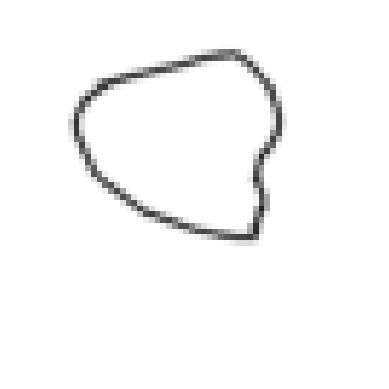

In [38]:
for image, label in trainloader:
    print(image.shape, label)
    # display image
    plt.imshow((image[0]).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    break

In [39]:
image.min(), image.max(), image.mean(), image.std()

(tensor(0.), tensor(1.), tensor(0.8208), tensor(0.2163))

In [40]:
# define a FC network 32x32 to 3 classes
class ShapeNet(nn.Module):
    def __init__(self, hidden_size=32):
        super(ShapeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, stride=2) # 64x64 -> 30x30
        self.conv2 = nn.Conv2d(8, 16, 5, stride=1) # 30x30 -> 26x26
        self.conv3 = nn.Conv2d(16, 32, 5, stride=1) # 26x26 -> 22x22
        self.conv4 = nn.Conv2d(32, 32, 5, stride=1) # 22x22 -> 18x18
        self.fc1 = nn.Linear(18*18*32, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(-1, 18*18*32)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [41]:
# create model + optimizer
model = ShapeNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# loss function: mse
criterion = nn.CrossEntropyLoss()
losses = []

In [42]:
num_epochs = 50
# train the model
for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    for image, label in trainloader:
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= len(trainloader)
    losses.append(running_loss)
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss:.4f}')

Epoch [1/50], Loss: 1.0995
Epoch [2/50], Loss: 1.0981
Epoch [3/50], Loss: 1.0937
Epoch [4/50], Loss: 1.0494
Epoch [5/50], Loss: 0.9775
Epoch [6/50], Loss: 0.9601
Epoch [7/50], Loss: 0.9321
Epoch [8/50], Loss: 0.8777
Epoch [9/50], Loss: 0.8536
Epoch [10/50], Loss: 0.8897
Epoch [11/50], Loss: 0.8547
Epoch [12/50], Loss: 0.9077
Epoch [13/50], Loss: 0.8358
Epoch [14/50], Loss: 0.8278
Epoch [15/50], Loss: 0.8394
Epoch [16/50], Loss: 0.8730
Epoch [17/50], Loss: 0.8965
Epoch [18/50], Loss: 0.8701
Epoch [19/50], Loss: 0.8779
Epoch [20/50], Loss: 0.8633
Epoch [21/50], Loss: 0.8274
Epoch [22/50], Loss: 0.8361
Epoch [23/50], Loss: 0.8436
Epoch [24/50], Loss: 0.8375
Epoch [25/50], Loss: 0.8256
Epoch [26/50], Loss: 0.8107
Epoch [27/50], Loss: 0.8157
Epoch [28/50], Loss: 0.8039
Epoch [29/50], Loss: 0.8037
Epoch [30/50], Loss: 0.8017
Epoch [31/50], Loss: 0.7984
Epoch [32/50], Loss: 0.8211
Epoch [33/50], Loss: 0.8958
Epoch [34/50], Loss: 0.8249
Epoch [35/50], Loss: 0.8104
Epoch [36/50], Loss: 0.8094
E

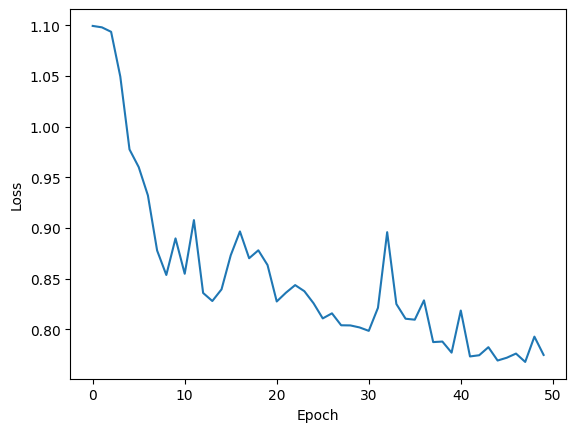

In [43]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

['circles', 'stars', 'triangles']


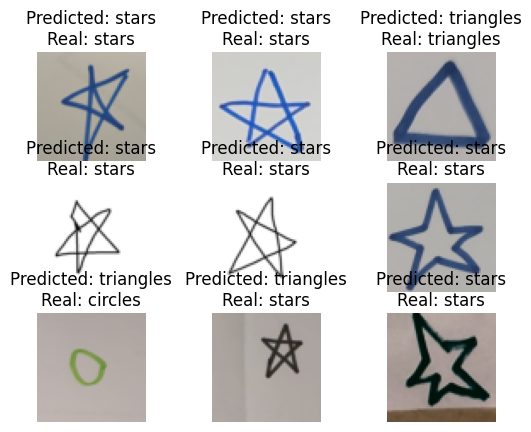

Accuracy: 62.50 %


In [44]:
class_names = dataset.classes
print(class_names)
plot = True
correct = 0
total = 0
for images, labels in testloader:
    predictions = model(images)
    if plot:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().swapaxes(0, 2).swapaxes(0, 1))
            pred_class = class_names[torch.argmax(predictions[i])]
            real_class = class_names[labels[i]]
            ax.set_title(f"Predicted: {pred_class}\nReal: {real_class}")
            plt.axis("off")
        plt.show()
        plot = False
    total += labels.size(0)
    correct += (torch.argmax(predictions, dim=1) == labels).sum().item()
    break
print(f"Accuracy: {100*correct/total:.2f} %")


In [45]:
correct = 0
total = 0
for images, labels in testloader:
    predictions = model(images)
    total += labels.size(0)
    correct += (torch.argmax(predictions, dim=1) == labels).sum().item()

print(f"Accuracy: {100*correct/total:.2f} %")

Accuracy: 65.95 %


In [46]:
# export as onnx model
dummy_input = image[:1]
torch.onnx.export(model, dummy_input, "shape_reco_draw.onnx", export_params=True, verbose=True)

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

